## DBSCAN — Density-Based Clustering (Unsupervised)

We’ll build an unsupervised clustering pipeline using DBSCAN:
	•	Data Exploration: synthesize non-convex clusters with noise (moons + blobs)
	•	Preprocessing: standardize features; k-distance plot to pick eps
	•	Modeling: fit DBSCAN; small manual “grid search” over (eps, min_samples) using silhouette score
	•	Evaluation: number of clusters (ex-noise), noise %; silhouette, ARI/NMI (since we know the synthetic ground truth); scatterplots

Key ideas: DBSCAN groups points into dense regions separated by sparser regions; labels -1 are noise.
Main hyperparameters: eps (neighborhood radius), min_samples (points to form a dense core), and metric.

## Setup

In [2]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Tuple, Optional, List
from IPython.display import display

# sklearn utilities
from sklearn.datasets import make_moons, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.8, 4.4)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll synthesize a 2-D dataset with two moons (non-convex) plus a small blob cluster and random noise.
This gives DBSCAN a chance to shine vs centroid-based methods.

Shape: (1020, 3)


,x1,x2,y_true
0,0.074079,1.000365,0
1,0.865218,-0.502625,1
2,0.104949,0.096827,1
3,0.256976,0.943966,0
4,-0.899192,0.226887,0


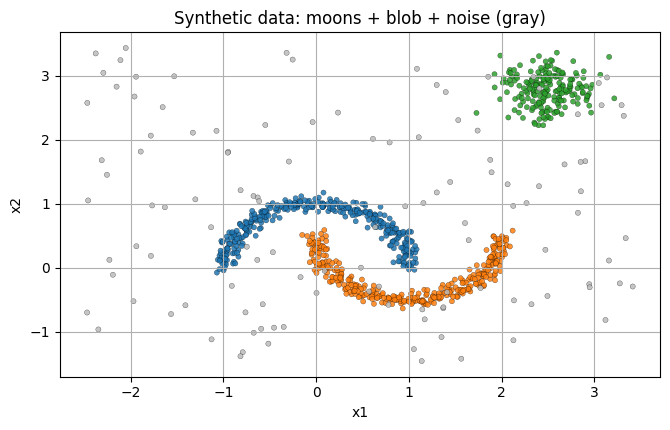

In [3]:
# Build a composite dataset: moons (non-convex) + one blob + uniform noise 
X1, y1 = make_moons(n_samples=700, noise=0.06, random_state=42)
X2, y2 = make_blobs(n_samples=200, centers=[(2.5, 2.8)], cluster_std=0.25, random_state=7)
# random noise
n_noise = 120
Xn = np.random.uniform(low=[-2.5, -1.5], high=[3.5, 3.5], size=(n_noise, 2))
yn = -np.ones(n_noise, dtype=int)  # mark as "noise" for ground truth reference only

# stack
X = np.vstack([X1, X2, Xn])
y_true = np.concatenate([y1, 2 * np.ones_like(y2), yn])  # 0/1 for moons, 2 for blob, -1 noise
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y_true"] = y_true

print("Shape:", df.shape)
display(df.head())

# quick scatter colored by ground truth (noise in gray)
palette = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", -1:"#BBBBBB"}
colors = [palette[v] for v in y_true]
plt.scatter(df.x1, df.x2, c=colors, s=14, edgecolor="k", linewidths=0.2, alpha=0.85)
plt.title("Synthetic data: moons + blob + noise (gray)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout(); plt.show()

## Preprocessing
	•	Standardize features (important for distance-based clustering).
	•	Use a k-distance plot (k = min_samples) to get a feel for a good eps (look for the “knee”).

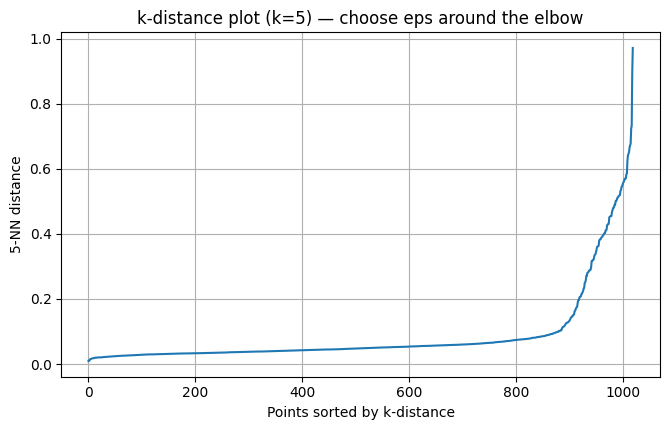

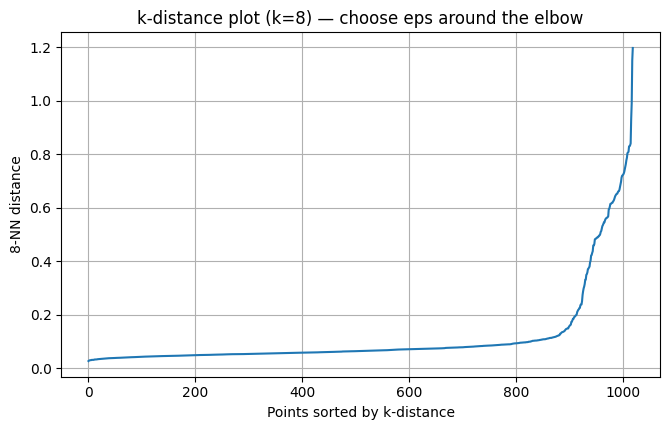

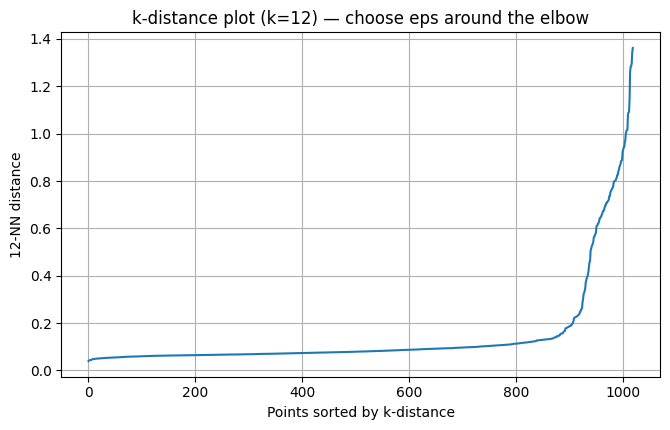

In [4]:
# Standardize
scaler = StandardScaler()
Xs = scaler.fit_transform(df[["x1", "x2"]].to_numpy())

# k-distance plot helper
def k_distance_plot(X: np.ndarray, k: int = 10):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    dists, _ = nbrs.kneighbors(X)
    # distance to kth neighbor is column k-1 (0-indexed)
    kth = np.sort(dists[:, k-1])
    plt.plot(kth)
    plt.title(f"k-distance plot (k={k}) — choose eps around the elbow")
    plt.xlabel("Points sorted by k-distance")
    plt.ylabel(f"{k}-NN distance")
    plt.tight_layout(); plt.show()

# Try a few k values (min_samples candidates)
for k in (5, 8, 12):
    k_distance_plot(Xs, k=k)

Modeling
	1.	Fit a baseline DBSCAN with a reasonable (eps, min_samples) choice (in standardized space).
	2.	Run a small manual grid search over (eps, min_samples) using silhouette (higher is better) to pick a better set.

In [5]:
# 1) Baseline DBSCAN 
baseline = DBSCAN(eps=0.25, min_samples=8, metric="euclidean")
labels_base = baseline.fit_predict(Xs)

def summarize(labels: np.ndarray) -> Dict[str, float]:
    n_noise = np.sum(labels == -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    frac_noise = n_noise / labels.size
    # silhouette only valid if >= 2 clusters and not all noise
    if n_clusters >= 2 and n_noise < labels.size:
        sil = silhouette_score(Xs[labels != -1], labels[labels != -1])
    else:
        sil = np.nan
    return {"clusters": n_clusters, "noise_frac": frac_noise, "silhouette": sil}

print("Baseline summary:", summarize(labels_base))

Baseline summary: {'clusters': 2, 'noise_frac': 0.08431372549019608, 'silhouette': 0.6808609465568094}


In [6]:
# 2) Small "grid search" over eps & min_samples using silhouette 
eps_list = np.round(np.linspace(0.15, 0.45, 7), 3)   # standardized distances
min_samples_list = [5, 8, 10, 12]

best = {"eps": None, "min_samples": None, "sil": -np.inf, "labels": None}
results = []

for eps in eps_list:
    for ms in min_samples_list:
        model = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
        labels = model.fit_predict(Xs)
        summary = summarize(labels)
        sil = summary["silhouette"]
        results.append((eps, ms, summary["clusters"], summary["noise_frac"], sil))
        if np.isfinite(sil) and sil > best["sil"]:
            best = {"eps": eps, "min_samples": ms, "sil": sil, "labels": labels}

res_df = pd.DataFrame(results, columns=["eps","min_samples","clusters","noise_frac","silhouette"]).sort_values(
    ["silhouette","clusters"], ascending=[False, False]
)
display(res_df.head(10))
print("Best:", best)
labels_best = best["labels"]

,eps,min_samples,clusters,noise_frac,silhouette
11,0.25,12,2,0.085294,0.681232
9,0.25,8,2,0.084314,0.680861
10,0.25,10,2,0.084314,0.680861
13,0.30,8,2,0.081373,0.679839
14,0.30,10,2,0.081373,0.679839
15,0.30,12,2,0.081373,0.679839
18,0.35,10,2,0.076471,0.676582
19,0.35,12,2,0.076471,0.676582
23,0.40,12,2,0.068627,0.672491
27,0.45,12,2,0.066667,0.671446


Best: {'eps': 0.25, 'min_samples': 12, 'sil': 0.6812320678158268, 'labels': array([ 0,  0,  0, ..., -1, -1,  0])}


## Evaluation

We’ll report: clusters (ex-noise), noise fraction, and silhouette (on non-noise points).
Because we built the data, we also compute ARI and NMI vs the ground truth (ignoring true noise).

Baseline -> clusters=2, noise%=8.4, silhouette=0.681, ARI=0.408, NMI=0.592


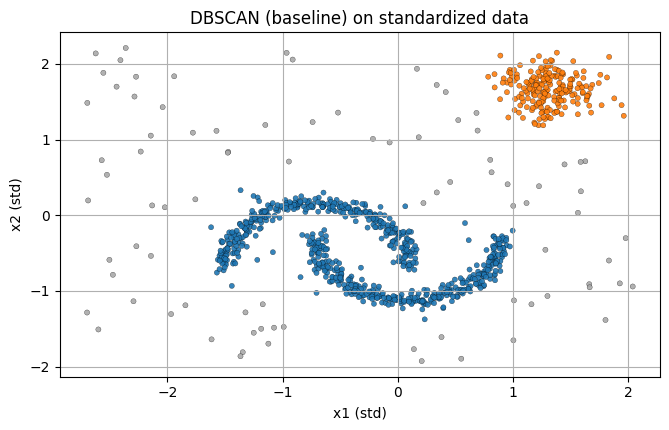

Best -> eps=0.25, min_samples=12 | clusters=2, noise%=8.5, silhouette=0.681, ARI=0.409, NMI=0.594


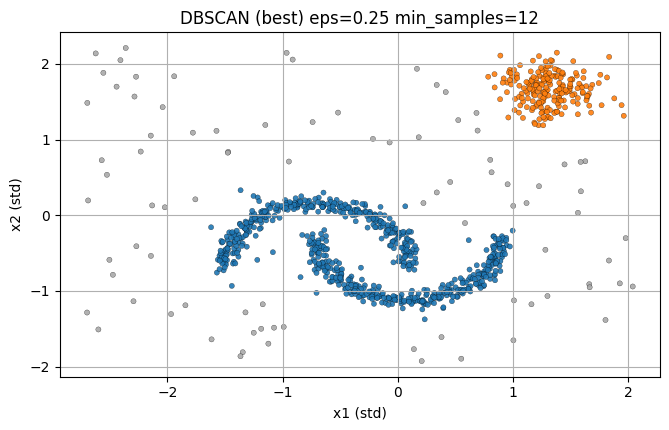

In [7]:
def external_scores(y_true_all: np.ndarray, labels_all: np.ndarray) -> Tuple[float,float]:
    """
    Compute ARI and NMI vs provided y_true.
    Ignore points labeled as -1 by DBSCAN (noise).
    """
    mask = labels_all != -1
    if mask.sum() == 0:
        return (np.nan, np.nan)
    # Filter both arrays; remove true noise label (-1) but keep cluster ids 0/1/2
    yt = y_true_all[mask]
    yp = labels_all[mask]
    # If only 1 cluster left after masking, ARI/NMI undefined
    if len(np.unique(yp)) < 2 or len(np.unique(yt)) < 2:
        return (np.nan, np.nan)
    ari = adjusted_rand_score(yt, yp)
    nmi = normalized_mutual_info_score(yt, yp)
    return (ari, nmi)

def plot_clusters(X: np.ndarray, labels: np.ndarray, title: str):
    # color by label; noise = -1 -> gray
    uniq = np.unique(labels)
    cmap = plt.get_cmap("tab10")
    color_map = {lab: ("#A9A9A9" if lab == -1 else cmap(int(lab) % 10)) for lab in uniq}
    cs = [color_map[l] for l in labels]
    plt.scatter(X[:,0], X[:,1], c=cs, s=14, edgecolor="k", linewidths=0.2, alpha=0.9)
    plt.title(title)
    plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.tight_layout(); plt.show()

# Baseline metrics
base_sum = summarize(labels_base)
base_ari, base_nmi = external_scores(y_true, labels_base)
print(f"Baseline -> clusters={base_sum['clusters']}, noise%={100*base_sum['noise_frac']:.1f}, silhouette={base_sum['silhouette']:.3f}, ARI={base_ari:.3f}, NMI={base_nmi:.3f}")
plot_clusters(Xs, labels_base, "DBSCAN (baseline) on standardized data")

# Best metrics
best_sum = summarize(labels_best)
best_ari, best_nmi = external_scores(y_true, labels_best)
print(f"Best -> eps={best['eps']}, min_samples={best['min_samples']} | clusters={best_sum['clusters']}, noise%={100*best_sum['noise_frac']:.1f}, silhouette={best_sum['silhouette']:.3f}, ARI={best_ari:.3f}, NMI={best_nmi:.3f}")
plot_clusters(Xs, labels_best, f"DBSCAN (best) eps={best['eps']} min_samples={best['min_samples']}")

## Key Takeaways
	•	DBSCAN discovers clusters of high density and labels outliers as noise (-1).
	•	Choosing eps and min_samples is crucial; the k-distance plot helps pick eps near the “knee.”
	•	Strengths: handles arbitrary shapes, robust to outliers, no need to pre-specify k.
	•	Limitations: sensitive to global eps when density varies; not suited to very high-dimensional spaces without care (consider PCA/UMAP).
	•	If you need automatic parameter selection or variable density, consider HDBSCAN (separate library) or OPTICS in scikit-learn.